In [21]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import Bidirectional
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras import optimizers
from keras.layers.merge import Concatenate
from keras.utils import plot_model
from keras.regularizers import l2

import pandas as pd
import numpy as np
import re

import score
from score import report_score

In [52]:
from numpy.random import seed
seed(1)

In [66]:
DATA_DIR = 'data/'

# These are some hyperparameters that were tuned
MAX_BODY_LEN = 200
MAX_HEAD_LEN = 20
MAX_VOCAB_SIZE = 30000
LSTM_DIM = 128
EMBEDDING_DIM = 200
BATCH_SIZE = 100
N_EPOCHS = 10
# REG_VALUE=0.001

In [67]:
train_bodies = pd.read_csv(DATA_DIR+'train_bodies.csv')
train_stances = pd.read_csv(DATA_DIR+'train_stances.csv')

test_bodies = pd.read_csv(DATA_DIR+'test_bodies.csv')
test_stances_unlabeled = pd.read_csv(DATA_DIR+'test_stances_unlabeled.csv')

train = train_stances.join(train_bodies.set_index('Body ID'), on='Body ID')
test = test_stances_unlabeled.join(test_bodies.set_index('Body ID'), on='Body ID')

In [68]:
def process_text(sen):    
    # Remove punctuations
    sentence = re.sub('[^a-zA-Z0-9]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [69]:
train['processed_headline']=train['Headline'].apply(process_text)
train['processed_body'] = train['articleBody'].apply(process_text)
test['processed_headline']=test['Headline'].apply(process_text)
test['processed_body'] = test['articleBody'].apply(process_text)
train.head(1)
test.head(1)

,Headline,Body ID,articleBody,processed_headline,processed_body
0,Ferguson riots: Pregnant woman loses eye after...,2008,A RESPECTED senior French police officer inves...,Ferguson riots Pregnant woman loses eye after ...,A RESPECTED senior French police officer inves...


In [70]:
from sklearn import preprocessing
from keras.utils import to_categorical
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
y_train = label_encoder.fit_transform(train.Stance.values)
y_train = to_categorical(y_train)
y_train

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [71]:
all_text = []
all_text.extend(list(train.processed_headline))
all_text.extend(list(train.processed_body))
all_text.extend(list(test.processed_headline))
all_text.extend(list(test.processed_body))
len(all_text)

150770

In [72]:
tokenizer = Tokenizer(MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(all_text)

In [73]:
X_train_headline = tokenizer.texts_to_sequences(train.processed_headline)
X_train_body = tokenizer.texts_to_sequences(train.processed_body)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

29308


In [74]:
X_test_headline = tokenizer.texts_to_sequences(test.processed_headline)
X_test_body = tokenizer.texts_to_sequences(test.processed_body)

In [75]:
competetion_bodies = pd.read_csv(DATA_DIR+'competition_test_bodies.csv')
competetion_stances = pd.read_csv(DATA_DIR+'competition_test_stances.csv')

comp = competetion_stances.join(competetion_bodies.set_index('Body ID'), on='Body ID')

In [76]:
y_actual = label_encoder.fit_transform(comp.Stance.values)
y_actual = to_categorical(y_actual)
y_actual

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [77]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

#GloVes Load

Glove = 'glove.6B.200d.txt'

glove2word2vec(glove_input_file=Glove, word2vec_output_file="gensim_glove_vectors.txt")
embeddings = gensim.models.KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [78]:
x_train_headline = pad_sequences(X_train_headline, padding='post', maxlen=MAX_HEAD_LEN)
x_train_body = pad_sequences(X_train_body, padding='post', maxlen=MAX_BODY_LEN)


x_test_headline = pad_sequences(X_test_headline, padding='post', maxlen=MAX_HEAD_LEN)
x_test_body = pad_sequences(X_test_body, padding='post', maxlen=MAX_BODY_LEN)

x_train_headline, x_val_headline,x_train_body,x_val_body, Y_train, Y_val = train_test_split(x_train_headline, x_train_body,y_train, random_state=10, test_size=0.2)


In [100]:
input_h = Input(shape=(MAX_HEAD_LEN,),name = 'Hedline_Input')
input_b = Input(shape=(MAX_BODY_LEN,), name = 'Body_Input')

embedding_layer_h = Embedding(vocab_size, 200, weights=[embeddings_matrix], trainable=True,mask_zero=True,name = "Headline_Emd")(input_h)
LSTM_Layer_h = LSTM(128,name = "Headline_LSTM")(embedding_layer_h)

embedding_layer_b = Embedding(vocab_size, 200, weights=[embeddings_matrix], trainable=True,mask_zero=True,name = "Body_Emd")(input_b)
LSTM_Layer_b = LSTM(128,name = "Body_LSTM")(embedding_layer_b)

concat_layer = Concatenate(name="Concatenate")([LSTM_Layer_h, LSTM_Layer_b])
dense_layer = Dense(100, activation='relu',name="Dense_Layer")(concat_layer)
output = Dense(4, activation='softmax',name="Final_Layer")(dense_layer)
model_ie = Model(inputs=[input_h, input_b], outputs=output)
optimizer = optimizers.Adam(lr=0.001)
model_ie.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
print(model_ie.summary())

Model: "functional_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Hedline_Input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
Body_Input (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
Headline_Emd (Embedding)        (None, 20, 200)      5861600     Hedline_Input[0][0]              
__________________________________________________________________________________________________
Body_Emd (Embedding)            (None, 200, 200)     5861600     Body_Input[0][0]                 
______________________________________________________________________________________

In [101]:
history = model_ie.fit(x=[x_train_headline, x_train_body], y=Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1, validation_data=([x_val_headline,x_val_body],Y_val))
score = model_ie.evaluate(x=[x_test_headline, x_test_body], y=y_actual, verbose=1)
y_predict = model_ie.predict(x=[x_test_headline, x_test_body])
outputs = [np.argmax(p) for p in y_predict]
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "agree"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "discuss"
    if outputs[i] == 3: outputs[i] = "unrelated"
print("Scores on the test set")
report_score(comp.Stance.values,outputs)

Epoch 1/10
400/400 [==============================] - 88s 220ms/step - loss: 0.6000 - accuracy: 0.7795 - val_loss: 0.4237 - val_accuracy: 0.8359
Epoch 2/10
400/400 [==============================] - 86s 214ms/step - loss: 0.3037 - accuracy: 0.8847 - val_loss: 0.2743 - val_accuracy: 0.8979
Epoch 3/10
400/400 [==============================] - 85s 212ms/step - loss: 0.1847 - accuracy: 0.9307 - val_loss: 0.2211 - val_accuracy: 0.9182
Epoch 4/10
400/400 [==============================] - 85s 213ms/step - loss: 0.1232 - accuracy: 0.9532 - val_loss: 0.1886 - val_accuracy: 0.9351
Epoch 5/10
400/400 [==============================] - 85s 212ms/step - loss: 0.0890 - accuracy: 0.9680 - val_loss: 0.1656 - val_accuracy: 0.9457
Epoch 6/10
400/400 [==============================] - 85s 213ms/step - loss: 0.0645 - accuracy: 0.9771 - val_loss: 0.1574 - val_accuracy: 0.9502
Epoch 7/10
400/400 [==============================] - 86s 214ms/step - loss: 0.0479 - accuracy: 0.9832 - val_loss: 0.1577 - val_ac

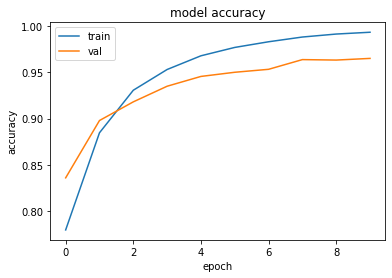

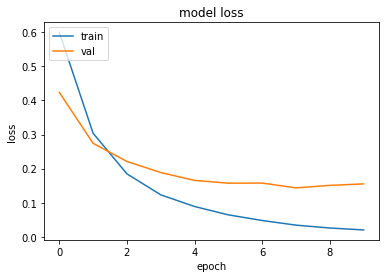

In [102]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [93]:
headline_lstm = LSTM(128, recurrent_dropout = 0.8, return_sequences = False, return_state = True, name="Headline_LSTM")
encoder_outputs, state_h, state_c = headline_lstm(embedding_layer_h)
encoder_states = [state_h, state_c]

article_lstm = LSTM(128, return_sequences = False,name="Body_LSTM_with_headline_encoded")
encoded_article = article_lstm(embedding_layer_b,initial_state=encoder_states)
# encoded_article = Dropout(.8)(encoded_article)

# dense_layer = Dense(100, activation='tanh',name="Dense_layer")(encoded_article)
output = Dense(4, activation='softmax',name="Final_layer")(encoded_article)
model_ce = Model(inputs=[input_h, input_b], outputs=output)
print(model_ce.summary())

Model: "functional_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Hedline_Input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
Body_Input (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
Headline_Emd (Embedding)        (None, 20, 200)      5861600     Hedline_Input[0][0]              
__________________________________________________________________________________________________
Body_Emd (Embedding)            (None, 200, 200)     5861600     Body_Input[0][0]                 
______________________________________________________________________________________

In [94]:
model_ce.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [95]:
history2 = model_ce.fit(x=[x_train_headline, x_train_body], y=Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1, validation_data=([x_val_headline,x_val_body],Y_val))

Epoch 1/10
400/400 [==============================] - 134s 335ms/step - loss: 0.4742 - accuracy: 0.8219 - val_loss: 0.4037 - val_accuracy: 0.8578
Epoch 2/10
400/400 [==============================] - 131s 327ms/step - loss: 0.2428 - accuracy: 0.9048 - val_loss: 0.2353 - val_accuracy: 0.9175
Epoch 3/10
400/400 [==============================] - 131s 328ms/step - loss: 0.1244 - accuracy: 0.9515 - val_loss: 0.2237 - val_accuracy: 0.9273
Epoch 4/10
400/400 [==============================] - 132s 330ms/step - loss: 0.0855 - accuracy: 0.9671 - val_loss: 0.2037 - val_accuracy: 0.9393
Epoch 5/10
400/400 [==============================] - 132s 329ms/step - loss: 0.0692 - accuracy: 0.9730 - val_loss: 0.1948 - val_accuracy: 0.9417
Epoch 6/10
400/400 [==============================] - 132s 329ms/step - loss: 0.0561 - accuracy: 0.9778 - val_loss: 0.2057 - val_accuracy: 0.9410
Epoch 7/10
400/400 [==============================] - 132s 330ms/step - loss: 0.0473 - accuracy: 0.9813 - val_loss: 0.2167 -

In [103]:
score = model_ce.evaluate(x=[x_test_headline, x_test_body], y=y_actual, verbose=1)
y_predict = model_ce.predict(x=[x_test_headline, x_test_body])
outputs = [np.argmax(p) for p in y_predict]
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "agree"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "discuss"
    if outputs[i] == 3: outputs[i] = "unrelated"
print("Scores on the test set")
report_score(comp.Stance.values,outputs)

795/795 [==============================] - 26s 32ms/step - loss: 2.0235 - accuracy: 0.6453
Scores on the test set
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    438    |    83     |    440    |    942    |
-------------------------------------------------------------
| disagree  |    112    |    31     |    155    |    399    |
-------------------------------------------------------------
|  discuss  |    440    |    111    |   2064    |   1849    |
-------------------------------------------------------------
| unrelated |   1415    |    286    |   2783    |   13865   |
-------------------------------------------------------------
Score: 6334.5 out of 11651.25	(54.36755712906341%)


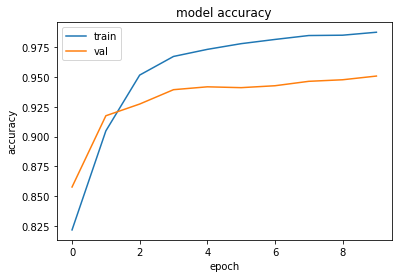

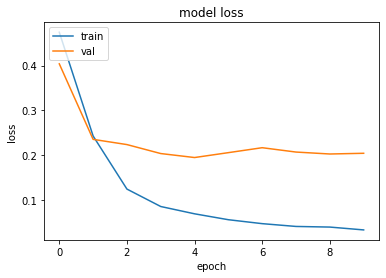

In [104]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [20]:
# model_ce.save('models/model_ie.h5')
model_ce.save('models/model_ce.h5')

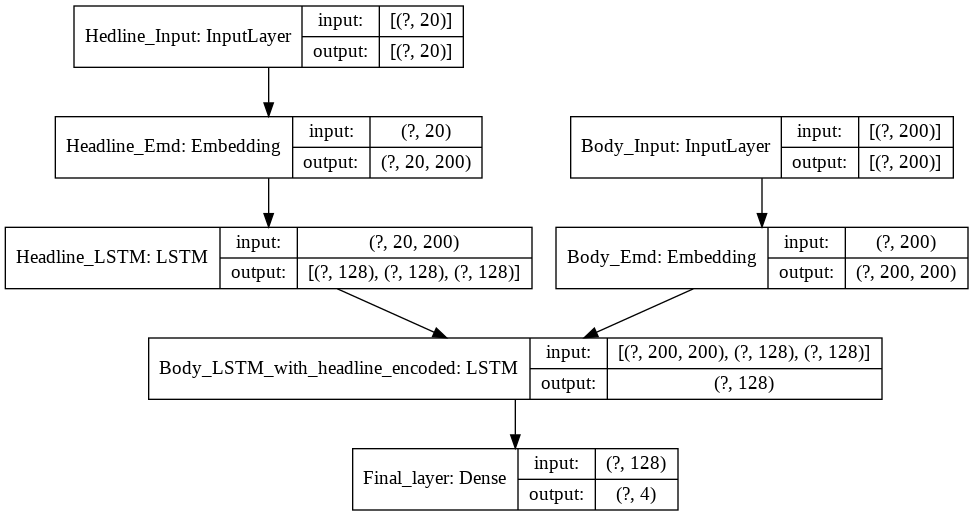

In [105]:

plot_model(model_ce, to_file='model_ce.png', show_shapes=True, show_layer_names=True)

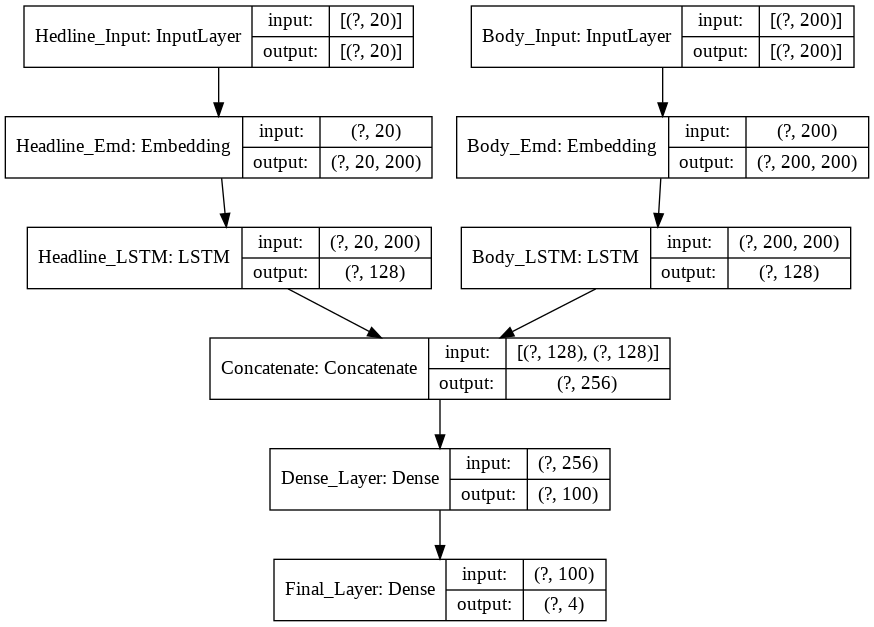

In [106]:
plot_model(model_ie, to_file='model_ie.png', show_shapes=True, show_layer_names=True)

In [ ]:
h,b=[],[]
for i in range(len(comp)):
  h.append(comp['Headline'][i])
  b.append(comp['Body ID'][i])
    
df = pd.DataFrame(data={"Headline" :h,"Body ID":b,"Stance":outputs})
df.to_csv("answer.csv",index=False,header=True,encoding='utf-8')